In [1]:
import cv2
from skimage.filters import threshold_adaptive
from skimage.transform import radon
import imutils
import argparse
import numpy as np
import scipy.signal
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import itertools
plt.rcParams['figure.figsize'] = (10.0, 8.0)
import mpld3
import scipy.optimize
mpld3.disable_notebook()

In [2]:
def auto_canny(image, sigma=0.33):
    median = np.median(image)
    lower_threshold = int(max(0, 1.0 - sigma) * median)
    upper_threshold = int(min(255, 1.0 + sigma) * median)
    edged = cv2.Canny(image, lower_threshold, upper_threshold)
    return edged

In [3]:
image = cv2.imread('test_whiteboards/cellphone_samples/whiteboard_skewed.jpg')

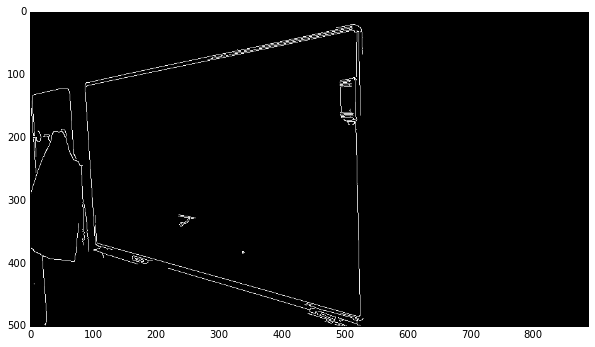

In [4]:
size_for_edge = 500
ratio = image.shape[0] / size_for_edge
image_resized = imutils.resize(image, height=size_for_edge)

gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
gray_blurred = cv2.GaussianBlur(gray, (5, 5), 1)
edged_auto = auto_canny(gray, sigma=0.5)
(_, cnts, _) = cv2.findContours(edged_auto.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_TC89_KCOS)
plt.imshow(edged_auto,cmap=plt.cm.Greys_r)

In [5]:
sinogram = radon(edged_auto, circle=False)

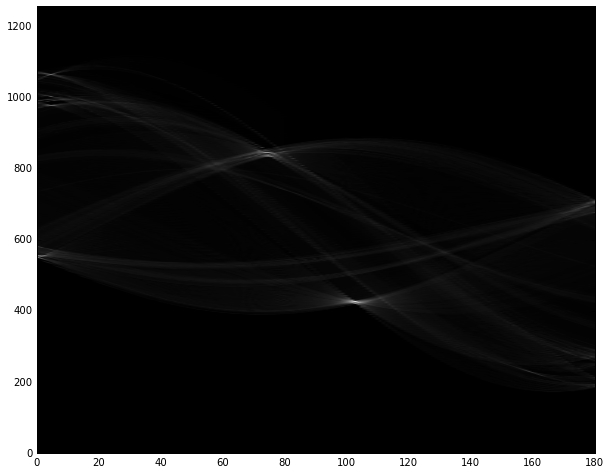

In [6]:
plt.imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')

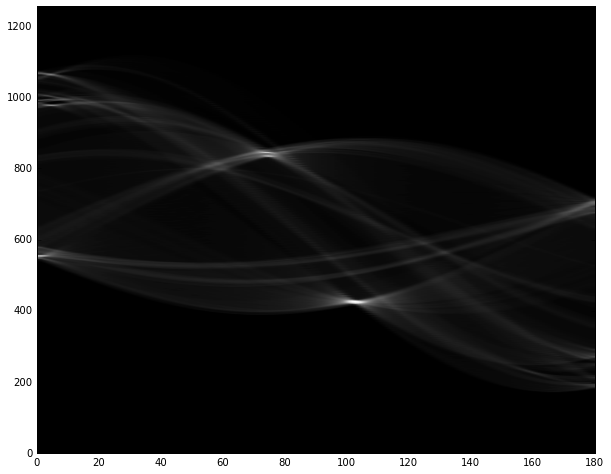

In [7]:
sino_blurred = cv2.GaussianBlur(sinogram, (5, 5), 1)
plt.imshow(sino_blurred, cmap=plt.cm.Greys_r, extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')

In [8]:
grey_show = lambda img: plt.imshow(img, cmap=plt.cm.Greys_r, aspect='auto')
def dilate(A, width):
    x_l = A.shape[0]
    y_l = A.shape[1]
    B = A.copy()
    for ii in range(x_l):
        for jj in range(y_l):
            xrange_l = max(ii-width,0)
            xrange_u = min(ii+width,x_l)
            yrange_l = max(jj-width,0)
            yrange_u = min(jj+width,y_l)
            B[ii,jj] = np.amax(A[xrange_l:xrange_u, yrange_l:yrange_u])
    return B

In [9]:
sino_flat = dilate(sino_blurred,5)

In [10]:
candidates = np.transpose(np.nonzero((sino_flat==sino_blurred)*sinogram))
vals = [sino_blurred[x,y] for (x,y) in candidates]
best_candidates = np.argsort(vals)[-30:]

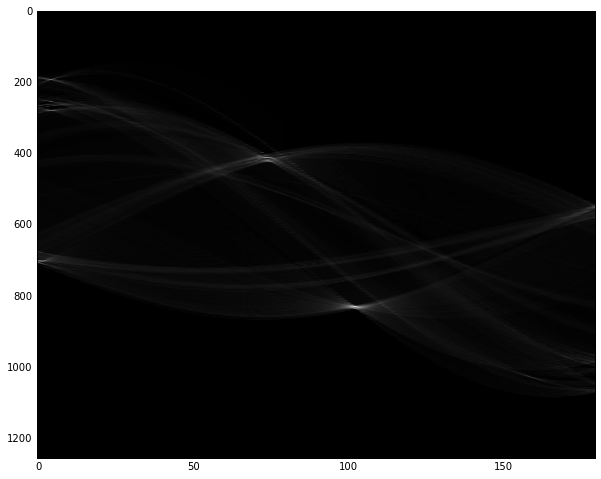

In [11]:
grey_show(sinogram)

In [12]:
def sino_to_point(angle,offset,shape):
    middle = np.array([shape[1]/2, shape[0]/2])
    max_offset = np.sqrt(2) * np.max(shape)
    offset_to_middle = offset - (max_offset/2)
    phi = angle / 180 * np.pi
    offset_dir_x = np.cos(phi)
    offset_dir_y = -np.sin(phi)
    offset_v = np.array([offset_dir_x * offset_to_middle, offset_dir_y * offset_to_middle])
    point_of_line = middle + offset_v
    return [point_of_line, point_of_line + 20 * np.array([offset_dir_y, -offset_dir_x])]

In [13]:
# How to find the corners of a rectangle?
# Idea: find two opposite sides first.
#       These can be defined in the following way: When starting from their intersection AB, the
#       intersections AC and AD need to have the same distance-order as BC and BD (or the triplet (AB,AC,AD)
#       must have the same order as the triplet (AB,BC,BD)).
def find_intersection(line1, line2, debug=False):
    #Find the intersection point between two lines. The lines are given by a pair of points on them.
    #Needs special cases that are missing! (x[0]==0,y[1]==0)
    x = line1[1] - line1[0]
    y = line2[1] - line2[0]
    c = line2[0] - line1[0]
    if(min(abs(x[0]),abs(y[1])) < min(abs(x[1]),abs(y[0]))):
        # To avoid divide by zero error, we switch the two lines
        return find_intersection(line2, line1)
    if debug:
        print(x,y,c)
    # a * x + b * y = c
    # a = (c[0] - b * y[0]) / x[0]
    # b = (c[1] - a * x[1]) / y[1]
    # b = (c[1] - (c[0] - b * y[0]) / x[0] * x[1]) / y[1]
    # b * (1 - y[0] / x[0] * x[1] / y[1]) = c[1] / y[1] - c[0] * x[1] / x[0] / y[1]
    b = (c[1] / y[1] - c[0] * x[1] / x[0] / y[1]) / (1 - y[0] / x[0] * x[1] / y[1])
    a = (c[0] - b * y[0]) / x[0]
    return np.array(line1[0] + a * (line1[1] - line1[0]))

def find_intersections(line1, otherlines):
    return [find_intersection(line1, ol) for ol in otherlines]

def order_points(points):
    """Orders points (given as list of coordinate tuples) that lie on a line.
    Tries to preserve order. Gives reordering as tuple of indices."""
    line_vec = points[1] - points[0]
    origin = points[0]
    distances = [np.dot(p - origin, line_vec) for p in points ]
    return np.argsort(distances)
    
def get_corners(lines):
    #Find the corners of a rectangle given by four lines. Probably crashes if two lines are exactly parallel.
    l = lines[0]
    otherlines = lines[1:]
    for (ii,ol) in enumerate(otherlines):
        inter = find_intersection(l, ol)
        rest = otherlines.copy()
        del rest[ii]
        inters1 = [inter] + find_intersections(l, rest)
        inters2 = [inter] + find_intersections(ol, rest)
        if np.all(order_points(inters1) == order_points(inters2)):
            # The two lines are opposite in the rectangle
            break;
    lines = [l, rest[0], ol, rest[1]]
    corners = [find_intersection(lines[ii], lines[(ii+1)%4]) for ii in range(4)]
    return (corners, lines)

In [14]:
max_offset = sinogram.shape[0]
middle=max_offset/2

def in_bucket(coords, bucket_size):
    x_min = bucket_size[0][0]
    x_max = bucket_size[0][1]
    y_min = bucket_size[1][0]
    y_max = bucket_size[1][1]
    y_match = coords[0] < y_max and coords[0] > y_min
    x_match = coords[1] < x_max and coords[1] > x_min if x_min < x_max else \
         not (coords[1] > x_max and coords[1] < x_min)
    return x_match and y_match

def into_buckets(coord_list, bucket_sizes):
    buckets=[[]]*4
    for (ii,c) in enumerate(coord_list):
        for (jj,b) in enumerate(bucket_sizes):
            if in_bucket(c,b):
                buckets[jj] = buckets[jj] + [ii]
    return buckets

In [15]:
def combinations(n,maxes):
    """This is a generator that returns all possible ways to distribute
    n tokens into len(maxes) buckets and where bucket n can only hold
    maxes[n] items."""
    if n <= sum(maxes):
        if len(maxes) == 1:
            yield [n]
        else:
            for ii in range(min(n+1,maxes[-1]+1)):
                for r in combinations(n-ii,maxes[:-1]):
                    yield r + [ii]
                    
def allcombinations(maxes):
    """This is a generator that returns all possible lists L of length
    len(maxes) with only integer entries and where for entry n holds:
    0<=L[n]<=maxes[n].
    The values are returned in the order of increasing sum(L).
    This is e.g. useful if we want to look at all possible combinations of
    items from len(maxes) buckets, where each bucket either holds infinitely
    many items or the items are ordered by their likelyhood."""
    for ii in range(sum(maxes)+1):
        for c in combinations(ii,maxes):
            yield c

In [16]:
def sinos_to_corners(sino_coords,shape):
    if len(sino_coords) != 4:
        return None
    lines = [sino_to_point(angle,offset, shape) for (offset, angle) in sino_coords]
    (corners, ls) = get_corners(lines)
    return corners

[4, 5, 7, 10, 12, 14, 27, 28]
[986 179] [703   0]
[280   4]
[[[60, 120], [659.4, 1256.0]], [[60, 120], [0, 439.59999999999997]], [[-1, 30], [659.4, 1256.0]], [[-1, 30], [0, 439.59999999999997]]]


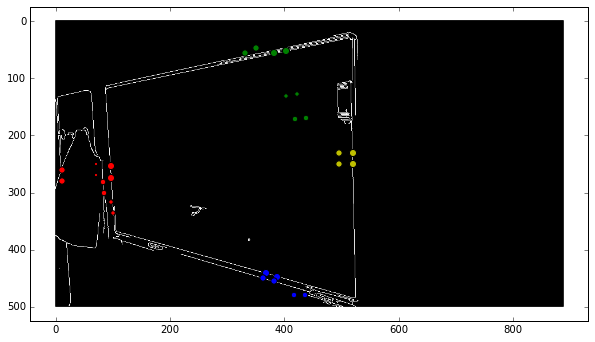

In [17]:
candidate_lines = candidates[best_candidates[::-1],:]
plt.imshow(edged_auto, cmap=plt.cm.Greys_r)

bucket_areas=[[[60,120],[middle*1.05,middle*2]],
              [[60,120],[0,middle*0.7]],
              [[-1,30],[middle*1.05,middle*2]],
              [[-1,30],[0,middle*0.7]]]
bucket_contents = into_buckets(candidate_lines, bucket_areas)

plt.imshow(edged_auto, cmap=plt.cm.Greys_r)
colors = ['g','b','y','r']
for jj in range(4):
    for (mm,c) in enumerate([candidate_lines[ii] for ii in bucket_contents[jj]]):
        (o,a) = c
        (p,p_v) = sino_to_point(a, o, edged_auto.shape)
        plt.scatter([p[0],p_v[0]],[p[1],p_v[1]],c=colors[jj],s=max(50-mm*10,0))
print(bucket_contents[3])
print(candidate_lines[9],candidate_lines[1])
print(candidate_lines[4])
print(bucket_areas)

[[0, 16, 21, 25], [2, 3, 17], [1, 13], [4, 5, 7, 10, 12, 14, 27, 28]]


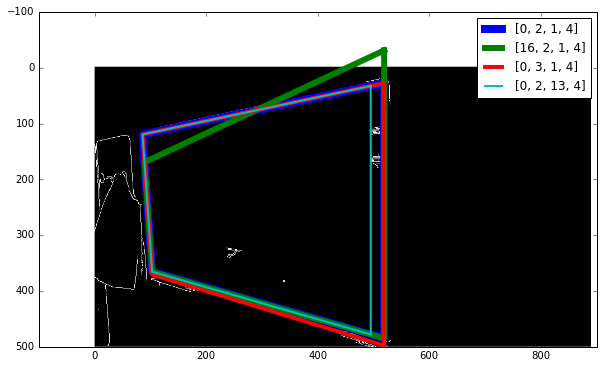

In [18]:
bucket_depths = [len(a)-1 for a in bucket_contents]
tst = 0;
print(bucket_contents)
plt.imshow(edged_auto, cmap=plt.cm.Greys_r)
maxlines = 3
for (ll,c) in enumerate(allcombinations(bucket_depths)):
    possible_rect = [bucket_contents[ii][c[ii]] for ii in range(4)]
    rect_coords = [candidate_lines[ii] for ii in possible_rect]
    corners = np.array(sinos_to_corners(rect_coords,edged_auto.shape))
    corners2=np.append(corners,corners[0:1,:],axis=0)
    plt.plot(corners2[:,0],corners2[:,1],label=str(possible_rect),linewidth=(1+maxlines-ll)*2)
    tst += 1
    if tst > maxlines:
        break
plt.legend()


True

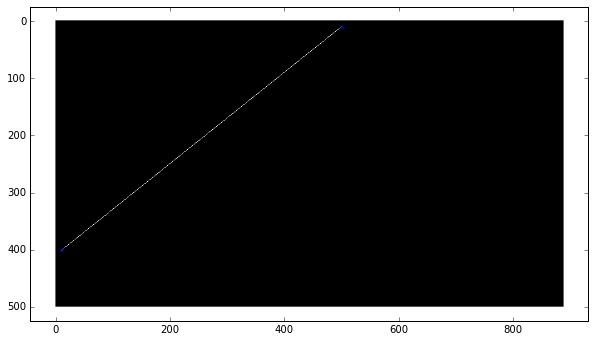

In [19]:
blank_slate = np.zeros_like(gray)
def bresen_line(array, p1, p2):
    switch_dim = np.abs(p1[0]-p2[0]) < np.abs(p1[1]-p2[1])
    if switch_dim:
        p1 = [p1[1],p1[0]]
        p2 = [p2[1],p2[0]]
    if p1[0] > p2[0]:
        (p1,p2) = (p2,p1)
    (x0,y0) = p1
    (x1,y1) = p2
    dx = x1 - x0
    dy = y1 - y0
    cur_offset = 0.0
    cur_y = y0
    if switch_dim:
        array[y0,x0] = 255
    else:
        array[x0,y0] = 255
    dy_by_dx = dy / dx
    dir = int(np.sign(dy_by_dx))
    dy_by_dx = np.abs(dy_by_dx)
    for cur_x in range(x0+1,x1+1):
        cur_offset += dy_by_dx
        if cur_offset > 0.5:
            cur_offset -= 1
            cur_y += dir
        if switch_dim:
            array[cur_y,cur_x] = 255
        else:
            array[cur_x,cur_y] = 255
    return array
x0 = [401,10]
x1 = [10,500]
test = bresen_line(blank_slate, x1, x0)
plt.imshow(test, cmap=plt.cm.Greys_r)
plt.scatter([x0[1],x1[1]],[x0[0],x1[0]],marker='s',alpha=0.5)
cv2.imwrite('test_out.png',test)

In [20]:
def bresen_sum(array, p1, p2, count=False):
    """This function is messy, slow and does not do proper bounds-checking.
    Refactor (maybe in Cython) at some point."""
    s = 0
    switch_dim = np.abs(p1[0]-p2[0]) < np.abs(p1[1]-p2[1])
    if switch_dim:
        p1 = [p1[1],p1[0]]
        p2 = [p2[1],p2[0]]
    if p1[0] > p2[0]:
        (p1,p2) = (p2,p1)
    (x0,y0) = p1
    (x1,y1) = p2
    dx = x1 - x0
    dy = y1 - y0
    cur_offset = 0.0
    cur_y = y0
    if switch_dim:
        s += array[x0,y0]
    else:
        s += array[y0,x0]
    dy_by_dx = dy / dx
    dir = int(np.sign(dy_by_dx))
    dy_by_dx = np.abs(dy_by_dx)
    tmp_n = 0
    a_s = np.zeros(x1-x0)
    try:
        for (ll,cur_x) in enumerate(range(x0+1,x1+1)):
            cur_offset += dy_by_dx
            a = 0
            if cur_offset > 0.5:
                cur_offset -= 1
                cur_y += dir
            if switch_dim:
                a = array[cur_x,cur_y] + 0.5 * (1.0 * array[cur_x, cur_y+1] + 1.0 * array[cur_x, cur_y-1]) + \
                                         0.25* (1.0 * array[cur_x, cur_y+2] + 1.0 * array[cur_x, cur_y-2])
            else:
                a = array[cur_y,cur_x] + 0.5 * (1.0 * array[cur_y+1, cur_x] + 1.0 * array[cur_y-1, cur_x]) + \
                                         0.25* (1.0 * array[cur_y+2, cur_x] + 1.0 * array[cur_y-2, cur_x])
            if a != 0.0:
                tmp_n += 1
            a_s[ll] = a
            s += a
    except IndexError:
        print(cur_x,cur_y,p1,p2, switch_dim)
    #print([(v,len(list(a))) for (v,a) in itertools.groupby(a_s)])
    return tmp_n if count else s


def bresen_avg(array, p1, p2, count=False):
    l = max([abs(p1[ii]-p2[ii]) for ii in (0,1)])
    return bresen_sum(array, p1, p2, count) / l    

[[0, 16, 21, 25], [2, 3, 17], [1, 13], [4, 5, 7, 10, 12, 14, 27, 28]]
[[519, 27], [519, 484], [103, 365], [86, 119]]
[[519, -31], [519, 484], [103, 365], [89, 169]]
0.6174757281553398
0.17209302325581396


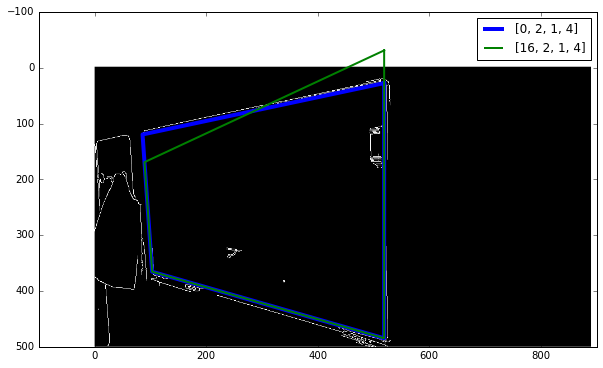

In [21]:
bucket_depths = [len(a)-1 for a in bucket_contents]
tst = 0;
print(bucket_contents)
plt.imshow(edged_auto, cmap=plt.cm.Greys_r)
maxlines = 1
for (ll,c) in enumerate(allcombinations(bucket_depths)):
    possible_rect = [bucket_contents[ii][c[ii]] for ii in range(4)]
    rect_coords = [candidate_lines[ii] for ii in possible_rect]
    corners = np.array(sinos_to_corners(rect_coords,edged_auto.shape))
    corners2=np.append(corners,corners[0:1,:],axis=0)
    plt.plot(corners2[:,0],corners2[:,1],label=str(possible_rect),linewidth=(1+maxlines-ll)*2)
    tst += 1
    summer = [[int(rc) for rc in r] for r in corners]
    print(summer)
    if(ll==1):
        print(bresen_avg(edged_auto, summer[0],summer[1], True))
        #print(bresen_avg(edged_auto, summer[1],summer[2], True))
        #print(bresen_avg(edged_auto, summer[2],summer[3], True))
        print(bresen_avg(edged_auto, summer[3],summer[0], True))

    if tst > maxlines:
        break
plt.legend()


In [24]:
%load_ext Cython

In [23]:
def wu_sort_points(p1,p2, dim):
    switch_dim = abs(p1[0]-p2[0]) < abs(p1[1]-p2[1])
    if switch_dim:
        p1 = p1[::-1]
        p2 = p2[::-1]
    if p1[0] > p2[0]:
        (p1,p2) = (p2,p1)
    return (p1,p2, switch_dim)


def wu_sum(array, p1, p2, count=False):
    """This function is messy, slow and does not do proper bounds-checking.
    Refactor (maybe in Cython) at some point."""
    (p1, p2, switch_dim) = wu_sort_points(p1, p2, array.shape)
    s = 0
    (x0,y0) = p1
    (x1,y1) = p2
    dx = x1 - x0
    dy = y1 - y0
    
    dy_by_dx = abs(dy / dx)
    dir = int(np.sign(dy))
        
    # Take care of the end points
    if not (isinstance(x0, int) and isinstance(x1, int) and isinstance(y0, int) and isinstance(y1, int)):
        proper_x0 = int(np.ceil(x0))
        proper_x1 = int(np.floor(x1))
        
        weight_first = proper_x0 - x0
        weight_last  = proper_x1 - x1
        
        if dir > 0:
            proper_y0 = int(np.floor(y0))
            proper_y1 = int(np.ceil(y1))
        else:
            proper_y0 = int(np.ceil(y0))
            proper_y1 = int(np.floor(y1))
        
        if weight_first != 0.0:
            fst_offset = np.abs(proper_y0 - y0) / weight_first

            if switch_dim:
                s += (array[proper_x0-1, proper_y0] + 
                      array[proper_x0-1, proper_y0 + dir] * fst_offset) * weight_first
            else:
                s += (array[proper_y0, proper_x0-1] + 
                      array[proper_y0 + dir, proper_x0-1] * fst_offset) * weight_first

        if weight_last != 0.0:
            lst_offset = np.abs(proper_y1 - y1) / weight_last

            if switch_dim:
                s += (array[proper_x1+1, proper_y1] +
                      array[proper_x1+1, proper_y1 - dir] * lst_offset) * weight_last
            else:
                 s += (array[proper_y1, proper_x1+1] +
                      array[proper_y1 - dir, proper_x1+1] * lst_offset) * weight_last
              
        cur_offset = np.abs(proper_y0 - y0) + dy_by_dx * weight_first
        cur_y = proper_y0
        x0 = proper_x0
        x1 = proper_x1
        
    tmp_n = 0
    try:
        for (ll,cur_x) in enumerate(range(x0+1,x1+1)):
            cur_offset += dy_by_dx
            a = 0
            if cur_offset > 1:
                cur_offset -= 1
                cur_y += dir
            if switch_dim:
                a = array[cur_x,cur_y] * (1-cur_offset) + array[cur_x,cur_y+dir] * cur_offset
            else:
                a = array[cur_y,cur_x] * (1-cur_offset) + array[cur_y+dir,cur_x] * cur_offset
            if a != 0.0:
                tmp_n += 1
            s += a
    except IndexError:
        print(cur_x,cur_y,p1,p2, switch_dim)
    #print(s)
    return tmp_n if count else s

def wu_avg(array, p1, p2, count=False):
    l = max([abs(p1[ii]-p2[ii]) for ii in (0,1)])
    retval = wu_sum(array, p1, p2, count) / l
    print(retval)
    return retval

In [24]:
full_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # This is larger by the factor of 'ratio'
full_edges = auto_canny(full_img, sigma=0.6)

In [112]:
def find_max_offsets(shape, x, norm, border):
    min_x = - (x[0]-border) / np.abs(norm[0]) if norm[0] != 0 else float("-Inf")
    min_y = - (x[1]-border) / np.abs(norm[1]) if norm[1] != 0 else float("-Inf")
    
    max_x = (shape[0] - x[0] - border) / np.abs(norm[0]) if norm[0] != 0 else float("Inf")
    max_y = (shape[1] - x[1] - border) / np.abs(norm[1]) if norm[1] != 0 else float("Inf")
    
    # Now sort this stuff correctly (swap min+max if norm is negative)
    if norm[0] < 0:
        [min_x, max_x] = [-max_x, -min_x]
    if norm[1] < 1:
        [min_y, max_y] = [-max_y, -min_y]
    
    return [np.max([min_x, min_y, -10]), np.min([max_x, max_y, 10])]


def edge_optimizer(edge_pic, start_a, start_b):
    x0,y0 = start_a
    x1,y1 = start_b
    
    angle = np.arctan2(x1-x0, y1-y0)
    normal = np.array([np.cos(angle), np.sin(angle)])
    
    x_a = np.array(start_a)
    x_b = np.array(start_b)
    #print(start_a, start_b, normal, angle)
    
    a_max_offsets = find_max_offsets(edge_pic.shape[1::-1], x_a, normal, 3)
    b_max_offsets = find_max_offsets(edge_pic.shape[1::-1], x_b, normal, 3)
    
    #print("Offsets")
    #print(a_max_offsets, b_max_offsets)
    
    def printargs(f):
        def f_decorated(*a,**args):
            print(a,args)
            return f(*a,**args)
        return f_decorated
    
    opt_target = lambda offsets: -wu_sum(edge_pic, x_a + offsets[0] * normal, x_b + offsets[1] * normal)
        
    def print_args2(f):
        def f_decorated(a):
            print("Opt Step")
            print(a,)
            res = opt_target(a)
            print(res)
            return res
        return f_decorated
    
    r_min = -3
    r_max = 3
    n_tries = 5
    rands = (np.random.random((n_tries,2)) * (r_max - r_min)) - (r_max-r_min)/2 + (r_min + r_max) * 2
    
    reses = [scipy.optimize.minimize(opt_target, rands[ii,:],bounds=[a_max_offsets,b_max_offsets])
             for ii in range(n_tries)]
        
    vals = [res.fun for res in reses]
    best = np.argmin(vals)
    offsets = reses[best].x

    # Something weird is going on with the optimization results (there are spurious results with the message NORM_OF_PROJECTED_GRADIENT_<=_PGTOL)
    #print("Vals",vals)
    #print("xs",[res.x for res in reses])
    #print("x_inits", rands)
 
    
    #print(offsets)
    #print([f(offsets) for f in constraints])
    #print(x_a,x_b,max_x,max_y)
    #print(reses[best].fun, vals)
    return np.array([x_a + offsets[0] * normal, x_b + offsets[1] * normal]), (normal, x_a, x_b)

0.656455142232
0.992788461538
1.0
0.986143187067

-35419.8677885 -77679.4016994
0.617475728155
0.992788461538
1.0
0.172093023256



/usr/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


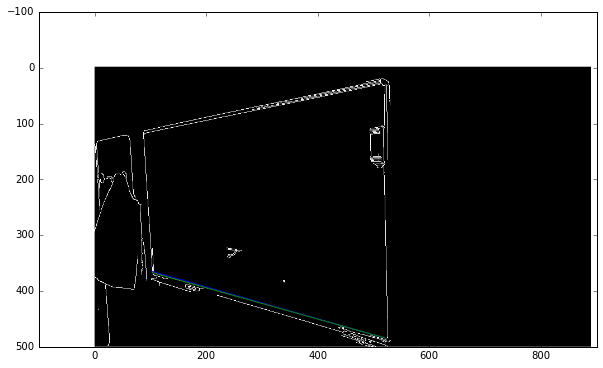

In [118]:
bucket_depths = [len(a)-1 for a in bucket_contents]
tst = 0;
#plt.imshow(edged_auto, cmap=plt.cm.Greys_r)
maxlines = 1
for (ll,c) in enumerate(allcombinations(bucket_depths)):
    possible_rect = [bucket_contents[ii][c[ii]] for ii in range(4)]
    rect_coords = [candidate_lines[ii] for ii in possible_rect]
    corners = np.array(sinos_to_corners(rect_coords,edged_auto.shape))
    corners2=np.append(corners,corners[0:1,:],axis=0)
    #plt.plot(corners2[:,0],corners2[:,1],label=str(possible_rect),linewidth=(1+maxlines-ll)*2)
    tst += 1
    summer = np.array([[int(rc) for rc in r] for r in corners])
    print(bresen_avg(edged_auto, summer[0],summer[1], True))
    print(bresen_avg(edged_auto, summer[1],summer[2], True))
    print(bresen_avg(edged_auto, summer[2],summer[3], True))
    print(bresen_avg(edged_auto, summer[3],summer[0], True))
    print()
    
    if ll==0:
        better_corners, (normal, x_a, x_b) = edge_optimizer(edged_auto, (summer[1]), (summer[2]))
        
        opt_target = lambda offsets: -wu_sum(edged_auto, x_a + offsets[0] * normal, x_b + offsets[1] * normal)

        #vals = [[opt_target([a,b]) for a in np.linspace(-10,10,20)] for b in np.linspace(-10,10,20)]
        #plt.imshow(vals)
        #x,y = np.mgrid[-10:10,-10:10]
        #plt.figimage(vals)
        
        #print("Better Corners",better_corners)
        print(opt_target([0,0]), -wu_sum(edged_auto, better_corners[0], better_corners[1]))
        plt.imshow(edged_auto,cmap=plt.cm.Greys_r)
        
        plt.plot(summer[1:3,0], summer[1:3,1])
        plt.plot(better_corners[:,0],better_corners[:,1])
    if tst > maxlines:
        break
plt.legend()
plt.show()

In [27]:
def wu_line(array, p1, p2):
    """This function is messy, slow and does not do proper bounds-checking.
    Refactor (maybe in Cython) at some point."""
    (p1, p2, switch_dim) = wu_sort_points(p1, p2, array.shape)
    s = 0
    (x0,y0) = p1
    (x1,y1) = p2
    dx = x1 - x0
    dy = y1 - y0
    
    in_x0 = np.ceil(x0) - x0
    dy_by_dx = abs(dy / dx)
    dir = np.sign(dy)
    
    cur_offset = in_x0 * dy_by_dx
    cur_y = y0
    
    if switch_dim:
        array[x0,y0] += int(in_x0 * 255)
    else:
        array[y0,x0] += int(in_x0 * 255)

    tmp_n = 0
    try:
        for (ll,cur_x) in enumerate(range(x0+1,x1+1)):
            cur_offset += dy_by_dx
            a = 0
            if cur_offset > 1:
                cur_offset -= 1
                cur_y += dir
            if switch_dim:
                array[cur_x,cur_y]     += int(255 * (1-cur_offset))
                array[cur_x,cur_y+dir] += int(255 * cur_offset)
            else:
                array[cur_y,cur_x]     += int(255 * (1-cur_offset))
                array[cur_y+dir,cur_x] += int(255 * cur_offset)
    except IndexError:
        print(cur_x,cur_y,p1,p2, switch_dim)
    return array

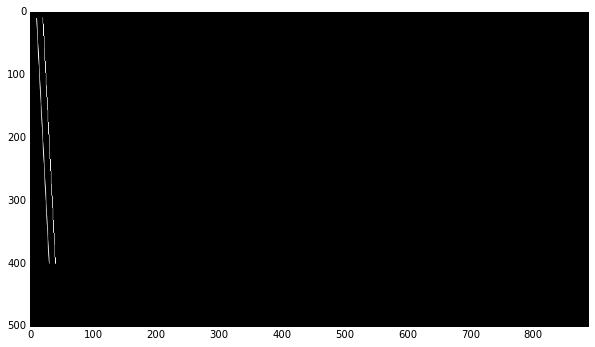

In [30]:
blank_slate = np.zeros_like(gray)
blank_slate2 = np.zeros_like(gray)

x1 = [30,400]
x0 = [10,10]
x1_2 = [400, 40]
x0_2 = [10, 20]
test = wu_line(blank_slate, x1, x0)
test2 = bresen_line(test, x1_2, x0_2)
plt.imshow(test2, cmap=plt.cm.Greys_r)

In [29]:
float("Inf")

inf

In [115]:
[1,2,3,4,5][0:2]

[1, 2]